In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
import matplotlib as mpl
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux, align_fluxes_by_reference
from scipy.spatial import cKDTree
import pandas as pd
from multiprocessing.dummy import Pool
from tqdm import tqdm
from astropy.nddata import Cutout2D
import glob
import pickle
import warnings
warnings.filterwarnings("ignore")

In [6]:
location = '/net/vdesk/data2/deklerk/GAAP_data'

In [18]:
field = '58.9_-48.6'

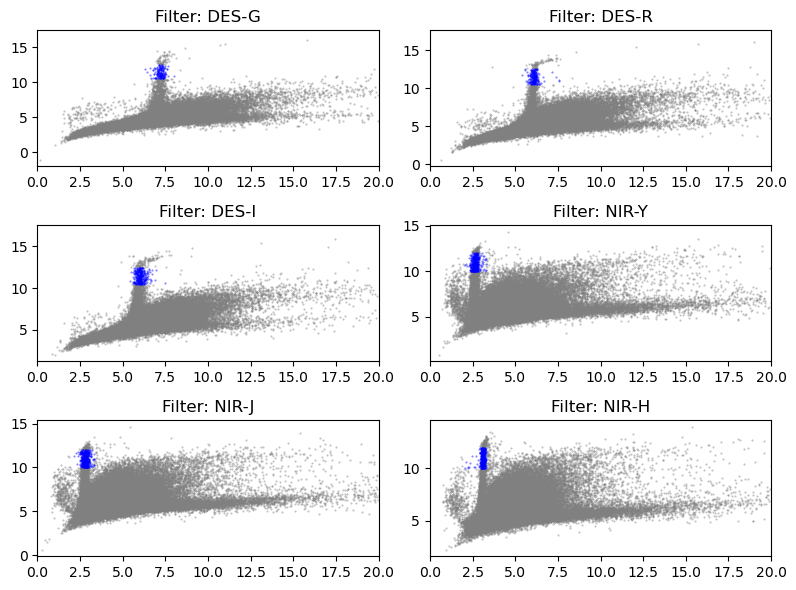

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(8, 6))
ax = ax.flatten()
filters = ['DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
for i, filter in enumerate(filters):
    catalog = Table.read(f'{location}/{field}/{filter}.cat', format='fits', hdu=2)
    if filter[:4] == 'DES-':
        mask = (
            (np.log(catalog['FLUX_AUTO']) > 10.5)
            & (np.log(catalog['FLUX_AUTO']) < 12.5)
            & (catalog['FLUX_RADIUS'] > 5)
            & (catalog['FLUX_RADIUS'] < 8.1)
        )
    else:
        mask = (
            (np.log(catalog['FLUX_AUTO']) > 10)
            & (np.log(catalog['FLUX_AUTO']) < 12)
            & (catalog['FLUX_RADIUS'] > 2)
            & (catalog['FLUX_RADIUS'] < 3.3)
        )
    ax[i].plot(catalog[~mask]['FLUX_RADIUS'], np.log(catalog[~mask]['FLUX_AUTO']), '.', ms=1, alpha=0.5, color='gray')
    ax[i].plot(catalog[mask]['FLUX_RADIUS'], np.log(catalog[mask]['FLUX_AUTO']), '.', ms=1, alpha=0.5, color='blue')
    ax[i].set_xlim(0, 20)
    ax[i].set_title(f'Filter: {filter}')
    # ax[i].set_xlabel('FLUX_RADIUS')
    # ax[i].set_ylabel('log(FLUX_AUTO)')
plt.tight_layout()
plt.show()

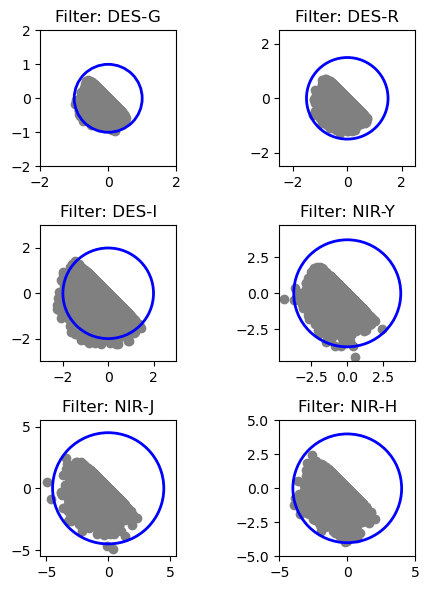

In [20]:
from matplotlib.patches import Circle
fig, ax = plt.subplots(3, 2, figsize=(5, 6))
ax = ax.flatten()

shift = 3

filters = ['DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
radii = [1, 1.5, 2, 3.7, 4.5, 4]
for i, filter in enumerate(filters):
    catalog = Table.read(f'{location}/{field}/{filter}.cat', format='fits', hdu=2)

    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")]

    with fits.open(image_file[0]) as hdul:
        image_data = hdul[0].data[:1000, :1000].copy()
    image_data = image_data.flatten()
    x = image_data[shift:]
    y = image_data[:-shift]
    mask = (x + y < 0)
    ax[i].scatter(x[mask], y[mask], color='gray')
    circle = plt.Circle((0, 0), radii[i], color='blue', fill=False, linewidth=2)
    ax[i].add_patch(circle)

    # ax[i].plot(catalog[mask]['FLUX_RADIUS'], np.log(catalog[mask]['FLUX_AUTO']), '.', ms=1, alpha=0.5, color='blue')
    ax[i].set_xlim(-radii[i]-1, radii[i]+1)
    ax[i].set_ylim(-radii[i]-1, radii[i]+1)
    ax[i].set_title(f'Filter: {filter}')
    ax[i].set_aspect('equal')
    # ax[i].set_xlabel('FLUX_RADIUS')
    # ax[i].set_ylabel('log(FLUX_AUTO)')
plt.tight_layout()
plt.show()

In [21]:
cutout_size = 21
aperture_size = 10
tile_size = 600 
filters = ['DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']
sigma = np.zeros(len(filters))
def process_filter(filter):
    catalog = Table.read(f'{location}/{field}/{filter}.cat', format='fits', hdu=2)

    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")]

    with fits.open(image_file[0]) as hdul:
        image_data = hdul[0].data.copy()

    ny, nx = image_data.shape

    if filter[:4] == 'DES-':
        mask = (
            (np.log(catalog['FLUX_AUTO']) > 10.5)
            & (np.log(catalog['FLUX_AUTO']) < 12.5)
            & (catalog['FLUX_RADIUS'] > 5)
            & (catalog['FLUX_RADIUS'] < 8.1)
        )
    else:
        mask = (
            (np.log(catalog['FLUX_AUTO']) > 10)
            & (np.log(catalog['FLUX_AUTO']) < 12)
            & (catalog['FLUX_RADIUS'] > 2)
            & (catalog['FLUX_RADIUS'] < 3.3)
        )
    
    
    cutouts = []
    for (x, y) in catalog[mask]['X_IMAGE', 'Y_IMAGE']:
        cutout = Cutout2D(image_data, (x, y), cutout_size, mode='partial', fill_value=np.nan)
        cutouts.append(cutout.data)
    psf = np.nanmean(cutouts, axis=0)

    # Split image into tiles
    x_edges = np.arange(0, nx + 1, tile_size)
    y_edges = np.arange(0, ny + 1, tile_size)

    df_tiles = []
    sigma_tile_list = []

    for y_start, y_end in zip(y_edges[:-1], y_edges[1:]):
        for x_start, x_end in zip(x_edges[:-1], x_edges[1:]):
            image_cut = image_data[y_start:y_end, x_start:x_end].copy()

            weight = gaussian_weight(
                image_cut.shape[0],
                image_cut.shape[1],
                image_cut.shape[0] / 2,
                image_cut.shape[1] / 2,
                aperture_size,
                aperture_size
            )

            mask_tile = (
                (catalog['X_IMAGE'] >= x_start) & (catalog['X_IMAGE'] < x_end) &
                (catalog['Y_IMAGE'] >= y_start) & (catalog['Y_IMAGE'] < y_end)
            )
            if np.sum(mask_tile) == 0:
                continue

            centers = [
                [xc - x_start, yc - y_start]
                for (xc, yc) in zip(catalog[mask_tile]['X_IMAGE'], catalog[mask_tile]['Y_IMAGE'])
            ]

            flux, sigma_tile = calculate_gaap_flux(image_cut, psf, weight, centers)
            sigma_tile_list.append(sigma_tile)

            df_tile = pd.DataFrame({
                'x': np.array(catalog[mask_tile]['X_IMAGE']),
                'y': np.array(catalog[mask_tile]['Y_IMAGE']),
                'flux': flux,
                'star': np.array(catalog[mask_tile]['CLASS_STAR'])
            })
            df_tiles.append(df_tile)

    sigma_value = np.mean(sigma_tile_list)
    df_filter = pd.concat(df_tiles, ignore_index=True)
    return filter, df_filter, sigma_value

with Pool(processes=6) as pool:  # one thread per filter
    results = list(tqdm(pool.imap(process_filter, filters), total=len(filters)))

# Collect results
sigma = np.zeros(len(filters))
filter_dfs = {}

for i, (filter, df_filter, sigma_val) in enumerate(results):
    sigma[i] = sigma_val
    filter_dfs[filter] = df_filter

G_df = filter_dfs['DES-G']
R_df = filter_dfs['DES-R']
I_df = filter_dfs['DES-I']
Y_df = filter_dfs['NIR-Y']
J_df = filter_dfs['NIR-J']
H_df = filter_dfs['NIR-H']

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [04:40<00:00, 46.80s/it] 


In [26]:
dfs = {
    'G': G_df,
    'R': R_df,
    'I': I_df,
    'Y': Y_df,
    'J': J_df,
    'H': H_df
}
with open(f'{location}/{field}/euclid_dataframe_aperture_{aperture_size}.pkl', 'wb') as f:
    pickle.dump(dfs, f)
bands, flux_matrix = align_fluxes_by_reference(dfs, max_dist=2.0)

print("Bands:", bands)
print("Flux matrix shape:", flux_matrix.shape)

Bands: ['G', 'R', 'I', 'Y', 'J', 'H']
Flux matrix shape: (45284, 6)


In [36]:
field = '58.9_-48.6'
field = '53.0_-28.0'

In [37]:
with open(f'{location}/{field}/euclid_dataframe_aperture_{aperture_size}.pkl', 'rb') as f:
    dfs = pickle.load(f)

In [40]:
filtered_dfs = {band: df[df['star'] >= 0.1] for band, df in dfs.items()}
bands, flux_matrix = align_fluxes_by_reference(filtered_dfs, max_dist=2.0)

print("Bands:", bands)
print("Flux matrix shape:", flux_matrix.shape)

Bands: ['G', 'R', 'I', 'Y', 'J', 'H']
Flux matrix shape: (649, 6)


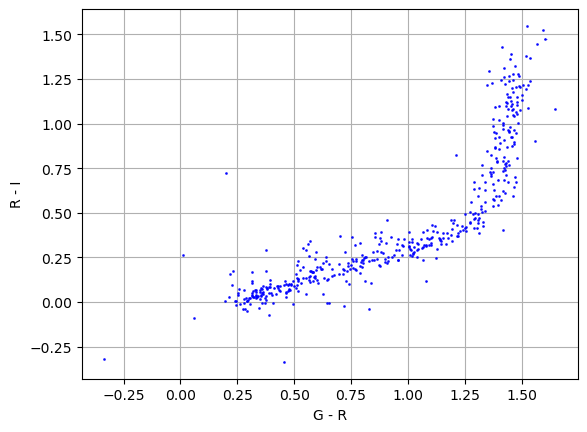

In [41]:
filter_1 = 0
filter_2 = 1
filter_3 = 2

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot the aperture colors with error
    # for fluxes in flux_matrix:
    x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
    y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

    xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)
    yerr = 2.5/np.log(10)*np.sqrt((sigma[filter_2]/flux_matrix[:,filter_2])**2+(sigma[filter_3]/flux_matrix[:,filter_3])**2)

    mask = (xerr**2 + yerr**2 < np.inf)
    # print("Number of points:", yerr)
    plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
    # plt.title(f'{field} with aperture size {aperture_size}')
    plt.grid(True)
    plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
    plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
    # plt.xlim(-1, 3)
    # plt.ylim(-0.5, 1.5)
    # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()

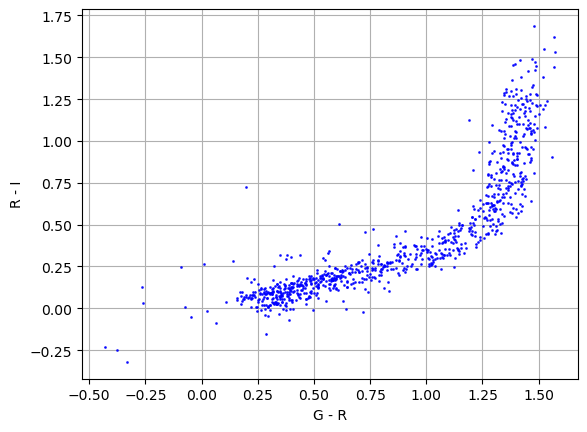

In [48]:
filter_1 = 0
filter_2 = 1
filter_3 = 2
prob_star_threshold = 0.2
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    for field in ['58.9_-48.6', '53.0_-28.0']:
        with open(f'{location}/{field}/euclid_dataframe_aperture_{aperture_size}.pkl', 'rb') as f:
            dfs = pickle.load(f)
        filtered_dfs = {band: df[df['star'] >= prob_star_threshold] for band, df in dfs.items()}
        bands, flux_matrix = align_fluxes_by_reference(filtered_dfs, max_dist=2.0)
        # Plot the aperture colors with error
        # for fluxes in flux_matrix:
        x_color = -2.5 * np.log10(flux_matrix[:,filter_1]/flux_matrix[:,filter_2])
        y_color = -2.5 * np.log10(flux_matrix[:,filter_2]/flux_matrix[:,filter_3])

        xerr = 2.5/np.log(10)*np.sqrt((sigma[filter_1]/flux_matrix[:,filter_1])**2+(sigma[filter_2]/flux_matrix[:,filter_2])**2)
        yerr = 2.5/np.log(10)*np.sqrt((sigma[filter_2]/flux_matrix[:,filter_2])**2+(sigma[filter_3]/flux_matrix[:,filter_3])**2)

        mask = (xerr**2 + yerr**2 < np.inf)
        # print("Number of points:", yerr)
        plt.errorbar(x_color[mask], y_color[mask], xerr=xerr[mask], yerr=yerr[mask], fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8)
        # plt.title(f'{field} with aperture size {aperture_size}')
        plt.grid(True)
        plt.xlabel(f'{bands[filter_1]} - {bands[filter_2]}')
        plt.ylabel(f'{bands[filter_2]} - {bands[filter_3]}')
        # plt.xlim(-1, 3)
        # plt.ylim(-0.5, 1.5)
        # plt.savefig(f'../../results/figures/CMD_{field}_{bands[filter_1]}{bands[filter_2]}{bands[filter_3]}.pdf')
    plt.show()
        

<BarContainer object of 6 artists>

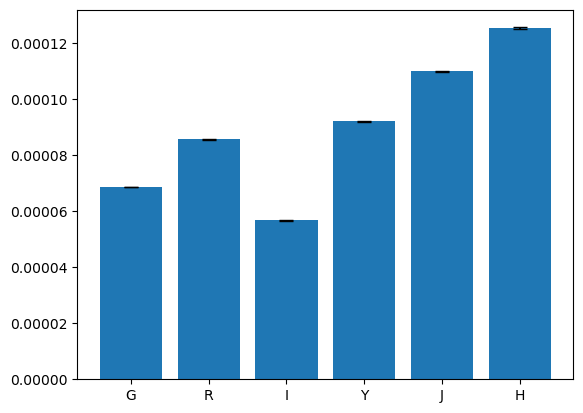

In [30]:
plt.bar(bands, np.nanmean(flux_matrix, axis=0), yerr=sigma, capsize=5)